# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
# Import Needed Packages
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from collections import deque
from ddpg_agent import Agent
import numpy as np
import random
import torch

%matplotlib inline

In [3]:
# Load Environment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# Get Default Brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# Reset Environment
env_info = env.reset(train_mode=True)[brain_name]

# Number Of Agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size Of Each Action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine The State Space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# Initiate Agent Object
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=3)

In [8]:
# Define DDPG Network
def DDPG(n_episodes=2000, max_t=2000):
    """
    This function implements Deep Deterministic Policy Gradient, wherein
    the following are the parameters:
    
    (int)n_episodes: Maximum Number Of Training Episodes
    (int)t_max: Maximum Number Of Timesteps Per Episode
    """
    
    # Init Scores
    scores_window = deque(maxlen=100)
    scores = []
    
    # Iterate Episodes
    for i_episode in range(1, n_episodes+1):
        # Reset Environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Obtain Current State
        states = env_info.vector_observations
                
        # Reset Agents
        agents.reset()
        
        # Init Episodic Scores (Each Agent)
        episode_scores = np.zeros(num_agents)
        
        # Iterate Timesteps
        for timestep in range(max_t):
            # Collect Needed Episode Parameters
            actions = agents.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done                  # See If Episode Finished
            
            # Step Agent To Next State
            agents.step(states, actions, rewards, next_states, dones, timestep)

            # Update State And Scores
            states = next_states
            episode_scores += rewards
             
            if np.any(dones):
                break 
                

        # Save Most Recent Score
        scores_window.append(np.max(episode_scores))
        scores.append(np.max(episode_scores))
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
            # Save Appropriate Weights As Checkpoints
            torch.save(agents.actor_local.state_dict(), 'ckpt_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'ckpt_critic.pth')
            break
     
    return scores

In [9]:
# Obtain DDGP Scores (Train Network)
scores = DDPG()

Episode 50	Average Score: 0.0098
Episode 100	Average Score: 0.0136
Episode 150	Average Score: 0.0137
Episode 200	Average Score: 0.0532
Episode 250	Average Score: 0.1037
Episode 300	Average Score: 0.1087
Episode 350	Average Score: 0.1085
Episode 400	Average Score: 0.1328
Episode 450	Average Score: 0.1540
Episode 500	Average Score: 0.2928
Episode 525	Average Score: 0.5012
Environment solved in 525 episodes!	Average Score: 0.50


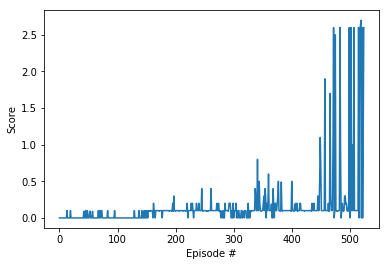

In [10]:
# Plot Scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
# Close Environment
env.close()